In [1]:
!nvidia-smi


Fri Mar 18 03:54:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1cGst2z4B385m9KZa6_8sBTv9DPpUieOd

file_id= "1cGst2z4B385m9KZa6_8sBTv9DPpUieOd"
# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=ce5c6299d9b2f6b0fc4b199fbda712b027b8748c943f104b93804c68cf3fcbb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-fc_wap7h/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cGst2z4B385m9KZa6_8sBTv9DPpUieOd
To: /content/PlantVillage.zip
100% 466M/466M [00:05<00:00, 82.6MB/s]
Downloading...
From: https://drive.google.com/uc

In [4]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [5]:

#Organizing the dataset
data_dir = '/content/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
nThreads = 4
batch_size = 32
diseases = os.listdir(train_dir)
print(diseases)
print(len(diseases))
use_gpu = torch.cuda.is_available()

['Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___Bacterial_spot', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Target_Spot', 'Potato___Early_blight', 'Tomato___healthy', 'Tomato___Early_blight', 'Pepper__bell___healthy', 'Potato___healthy', 'Tomato___Tomato_YellowLeaf__Curl_Virus']
15


In [6]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Tomato___Septoria_leaf_spot                             1771
Tomato___Spider_mites_Two_spotted_spider_mite           1676
Pepper__bell___Bacterial_spot                            997
Potato___Late_blight                                    1000
Tomato___Bacterial_spot                                 2127
Tomato___Tomato_mosaic_virus                             373
Tomato___Late_blight                                    1909
Tomato___Leaf_Mold                                       952
Tomato___Target_Spot                                    1404
Potato___Early_blight                                   1000
Tomato___healthy                                        1591
Tomato___Early_blight                                   1000
Pepper__bell___healthy                                  1478
Potato___healthy                                         152
Tomato___Tomato_YellowLeaf__Curl_Virus                  3209

Text(0.5, 1.0, 'Images per each class of plant disease')

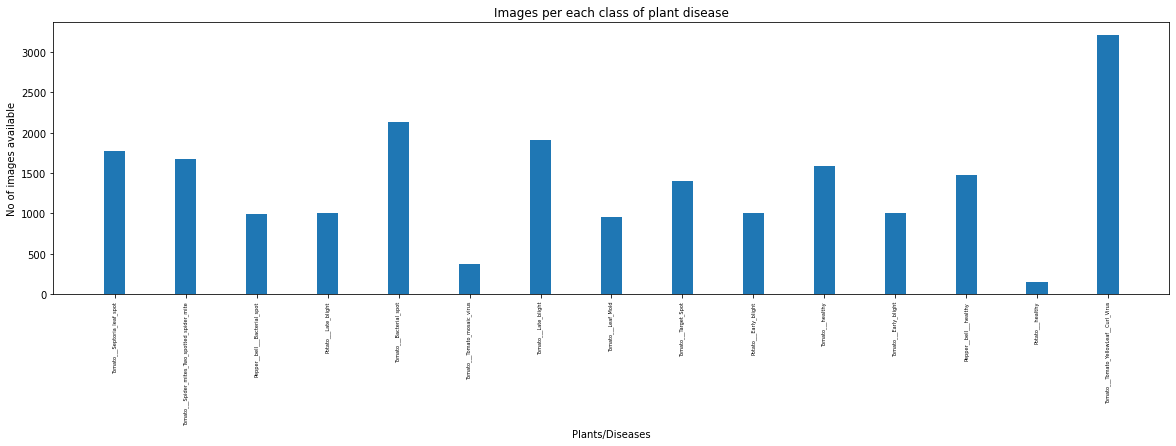

In [7]:
# plotting number of images available for each disease
index = [n for n in range(15)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [8]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 20639 images for training


In [9]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 


In [10]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [11]:
# total number of classes in train set
len(train.classes)

15

In [12]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Pepper__bell___Bacterial_spot(0)


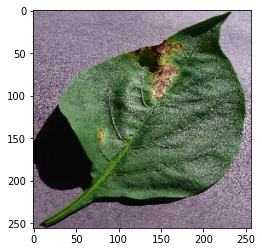

In [13]:
show_image(*train[1])

In [14]:

# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [15]:
# setting the batch size
batch_size = 32

In [16]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [17]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

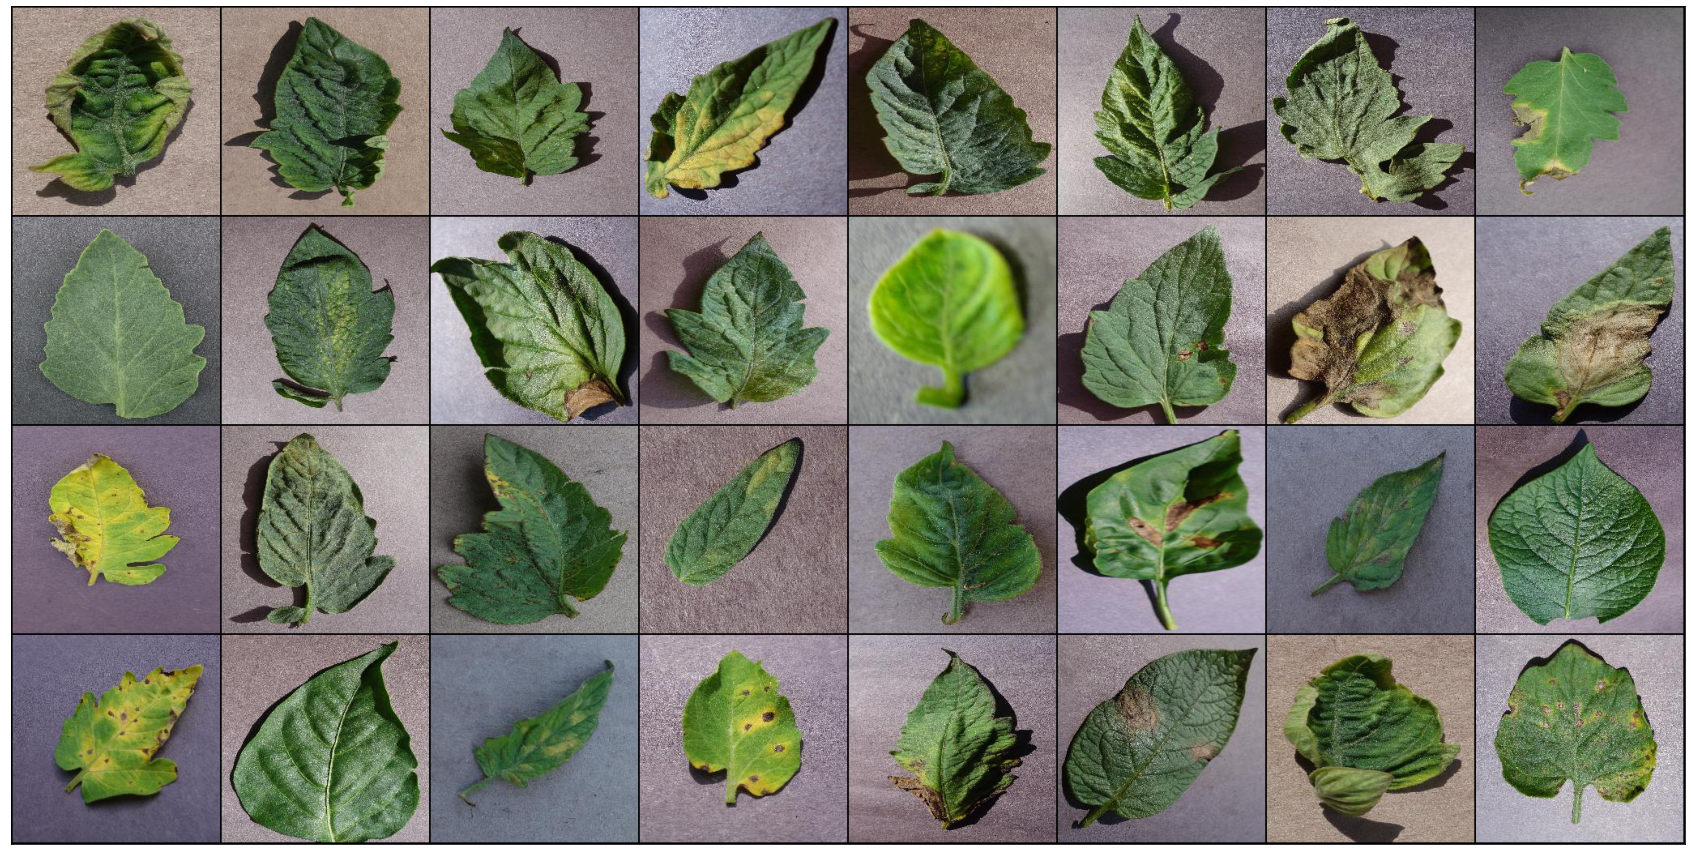

In [18]:
# Images for first batch of training
show_batch(train_dl) 

In [19]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    train_on_gpu = torch.cuda.is_available()

    if not train_on_gpu:
        return torch.device("cpu")
    else:
        return torch.device("cuda")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
print(device)

cuda


In [21]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [22]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [23]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [24]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [25]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [26]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [27]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [28]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 24.1 s, sys: 1.35 s, total: 25.5 s
Wall time: 30 s


In [29]:
epochs = 2
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [30]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00081, train_loss: 0.6337, val_loss: 1.3449, val_acc: 0.7025
Epoch [1], last_lr: 0.00000, train_loss: 0.1056, val_loss: 0.3771, val_acc: 0.9277
CPU times: user 6min 17s, sys: 5min 53s, total: 12min 11s
Wall time: 12min 4s


In [31]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

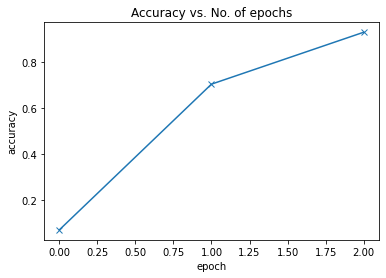

In [32]:
plot_accuracies(history)

In [33]:
#https://drive.google.com/file/d/1WU0xSUbaslJJeaShGHw5O2za9n11n_eL/view?usp=sharing
#!pip install --upgrade --no-cache-dir gdown
!gdown --id 1WU0xSUbaslJJeaShGHw5O2za9n11n_eL
file_id= "1WU0xSUbaslJJeaShGHw5O2za9n11n_eL"
# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

!unzip -q /content/test.zip



/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1WU0xSUbaslJJeaShGHw5O2za9n11n_eL
To: /content/test.zip
100% 251k/251k [00:00<00:00, 10.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WU0xSUbaslJJeaShGHw5O2za9n11n_eL
To: /content/test.zip
100% 251k/251k [00:00<00:00, 9.89MB/s]


In [34]:
test_dir = "/content/test"
print(os.listdir(test_dir))
test = ImageFolder(test_dir, transform=transforms.ToTensor())

['test']


In [35]:
test_images = sorted(os.listdir(test_dir+"/test")) # since images in test folder are in alphabetical order
test_images

['TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [36]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: TomatoEarlyBlight2.JPG , Predicted: Tomato___Early_blight


'/content/test/test/TomatoEarlyBlight1.JPG'

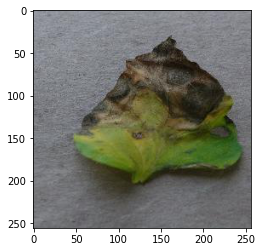

In [57]:
# predicting first image
img_id = 1
img, label = test[img_id]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[img_id], ', Predicted:', predict_image(img, model))

test_img_path=test_dir+"/test/"+test_images[img_id]
path


In [38]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: TomatoEarlyBlight1.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight2.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight3.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight4.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight5.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight6.JPG , Predicted: Tomato___Early_blight
Label: TomatoHealthy1.JPG , Predicted: Tomato___healthy
Label: TomatoHealthy2.JPG , Predicted: Tomato___healthy
Label: TomatoHealthy3.JPG , Predicted: Tomato___healthy
Label: TomatoHealthy4.JPG , Predicted: Tomato___healthy
Label: TomatoYellowCurlVirus1.JPG , Predicted: Tomato___Tomato_YellowLeaf__Curl_Virus
Label: TomatoYellowCurlVirus2.JPG , Predicted: Tomato___Tomato_YellowLeaf__Curl_Virus
Label: TomatoYellowCurlVirus3.JPG , Predicted: Tomato___Tomato_YellowLeaf__Curl_Virus
Label: TomatoYellowCurlVirus4.JPG , Predicted: Tomato___Tomato_YellowLeaf__Curl_Virus
Label: TomatoYellowCurlVirus5.JPG , Predic

In [58]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import sys
from google.colab.patches import cv2_imshow
import cv2

In [59]:
# load the input image from disk, resize it, and grab its spatial
# dimensions
print("[INFO] loading input image and source image...")
image = cv2.imread('/content/2022-03-17 21_01_23-Window.png')
image = imutils.resize(image, width=600)
(imgH, imgW) = image.shape[:2]
# load the source image from disk
source = cv2.imread(test_img_path)

[INFO] loading input image and source image...


In [60]:
# load the ArUCo dictionary, grab the ArUCo parameters, and detect
# the markers
print("[INFO] detecting markers...")
arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)
arucoParams = cv2.aruco.DetectorParameters_create()
(corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict,
	parameters=arucoParams)
# if we have not found four markers in the input image then we cannot
# apply our augmented reality technique
if len(corners) != 4:
	print("[INFO] could not find 4 corners...exiting")
	sys.exit(0)

[INFO] detecting markers...


In [61]:
# otherwise, we've found the four ArUco markers, so we can continue
# by flattening the ArUco IDs list and initializing our list of
# reference points
print("[INFO] constructing augmented reality visualization...")
ids = ids.flatten()
refPts = []
# loop over the IDs of the ArUco markers in top-left, top-right,
# bottom-right, and bottom-left order
for i in (923, 1001, 241, 1007):
	# grab the index of the corner with the current ID and append the
	# corner (x, y)-coordinates to our list of reference points
	j = np.squeeze(np.where(ids == i))
	corner = np.squeeze(corners[j])
	refPts.append(corner)

[INFO] constructing augmented reality visualization...


In [62]:
# unpack our ArUco reference points and use the reference points to
# define the *destination* transform matrix, making sure the points
# are specified in top-left, top-right, bottom-right, and bottom-left
# order
(refPtTL, refPtTR, refPtBR, refPtBL) = refPts
dstMat = [refPtTL[0], refPtTR[1], refPtBR[2], refPtBL[3]]
dstMat = np.array(dstMat)
# grab the spatial dimensions of the source image and define the
# transform matrix for the *source* image in top-left, top-right,
# bottom-right, and bottom-left order
(srcH, srcW) = source.shape[:2]
srcMat = np.array([[0, 0], [srcW, 0], [srcW, srcH], [0, srcH]])
# compute the homography matrix and then warp the source image to the
# destination based on the homography
(H, _) = cv2.findHomography(srcMat, dstMat)
warped = cv2.warpPerspective(source, H, (imgW, imgH))

In [63]:
# construct a mask for the source image now that the perspective warp
# has taken place (we'll need this mask to copy the source image into
# the destination)
mask = np.zeros((imgH, imgW), dtype="uint8")
cv2.fillConvexPoly(mask, dstMat.astype("int32"), (255, 255, 255),
	cv2.LINE_AA)
# this step is optional, but to give the source image a black border
# surrounding it when applied to the source image, you can apply a
# dilation operation
rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
mask = cv2.dilate(mask, rect, iterations=2)
# create a three channel version of the mask by stacking it depth-wise,
# such that we can copy the warped source image into the input image
maskScaled = mask.copy() / 255.0
maskScaled = np.dstack([maskScaled] * 3)
# copy the warped source image into the input image by (1) multiplying
# the warped image and masked together, (2) multiplying the original
# input image with the mask (giving more weight to the input where
# there *ARE NOT* masked pixels), and (3) adding the resulting
# multiplications together
warpedMultiplied = cv2.multiply(warped.astype("float"), maskScaled)
imageMultiplied = cv2.multiply(image.astype(float), 1.0 - maskScaled)
output = cv2.add(warpedMultiplied, imageMultiplied)
output = output.astype("uint8")

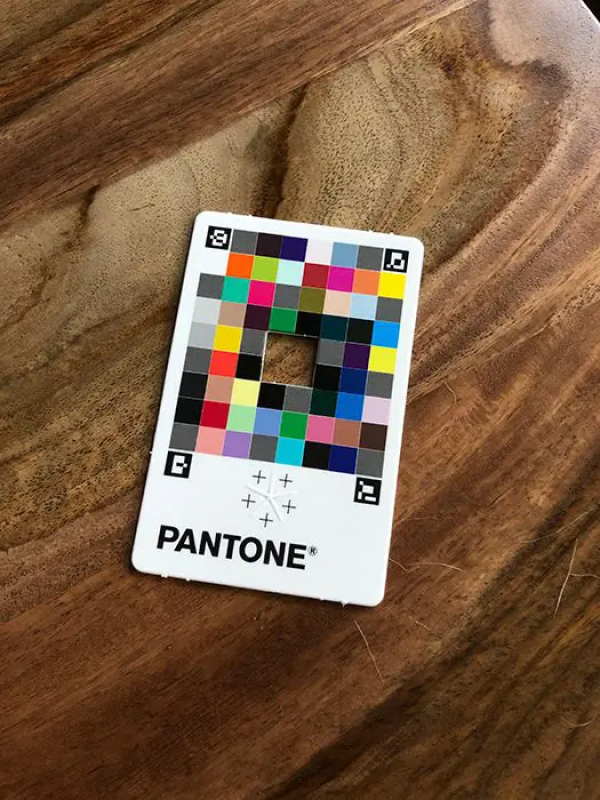

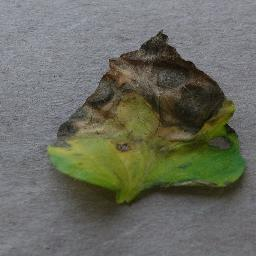

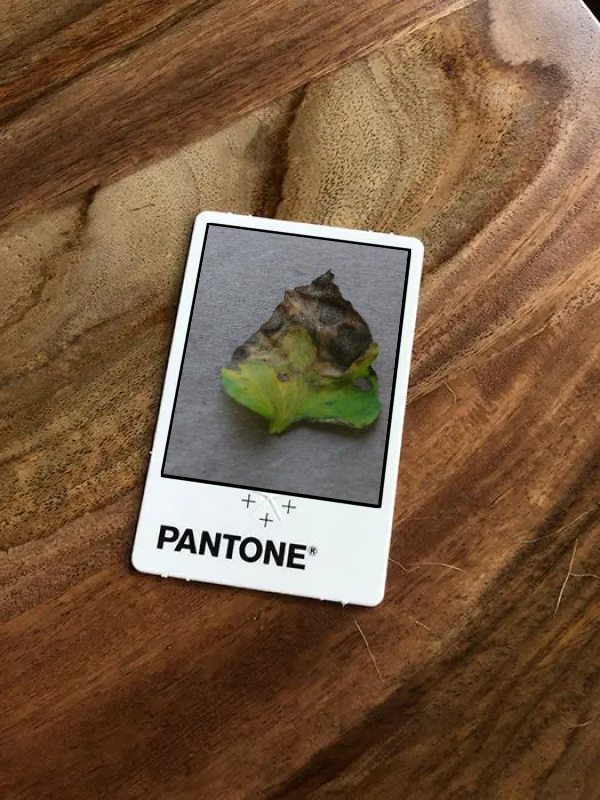

-1

In [66]:
# show the input image, source image, output of our augmented reality
cv2_imshow(image)
cv2_imshow( source)
cv2_imshow(output)
cv2.waitKey(0)